## <font color='blue'>Load necessary library files and setup important variables</font>

In [1]:
# Load necessary library files
import azure.ai.textanalytics
from azure.ai.textanalytics import TextAnalyticsClient
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import string
import json
import re
from PIL import Image
from colorama import Fore, Back, Style
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
%matplotlib inline

# Uncomment and replace the next two variables with the information from your Azure Cognitive Services
#key = "<paste-your-text-analytics-key-here>"
#endpoint = "<paste-your-text-analytics-endpoint-here>"

## <font color='blue'>Helper functions</font>

In [2]:
def get_text_analytics_client():
    """
    Input:
        None           
    Output:
         A Text Analytics Client Connection
    """
    text_analytics_client = TextAnalyticsClient(endpoint, key)
    
    return text_analytics_client


def get_comment_sentiment(df2, batchsize=750):
    """
    Analyze the comments in the data frame using the SDK to return the overall sentiment
    Input:
        df2: Data containing the comments
        batchsize: The maximum  number of documents to be processed per request. Default is 750
    Output:
         A data frame with additional column for the sentiment
    """    
    # Get client for Text Analytics
    __text_client = get_text_analytics_client()
    
    # Make a copy of the data frame
    dfx = df2.copy()
    dfx.reset_index(drop=True, inplace=True) 
    dfx["Sentiment"] = ""
    documents = []
    results =  []
    for i, row in dfx.iterrows():
        comment = dfx.loc[i,"Comment"].encode("utf-8").decode("ascii", "ignore")
        documents.append(comment)
    
    chunks = []
    for i in range(0, len(documents), batchsize): 
        chunks.append(documents[i:i+batchsize])

    result_chunks = []
    all_results = []
    for i in range(len(chunks)):
        cid = i
        documents = chunks[i]
        try:
            response = __text_client.analyze_sentiment(documents, language="en")
            data = [doc for doc in response if not doc.is_error]

            for doc in data:
                recid = (cid * batchsize)+ int(doc.id)
                dfx.loc[recid,"Sentiment"] = doc.sentiment.capitalize()
        except Exception as e:
            print("[Errno {0}] {1}".format(e.errno, e.strerror))
    return dfx


def language_detection(df2, language="English", batchsize=750):
    """
    Analyze the comments in the data frame using the SDK to detect the language of comment
    Input:
        df2: Data containing the comments
        language: Default is English
        batchsize: The maximum  number of documents to be processed per request. Default is 750
    Output:
         A dictionary of list containing all comments that are different from the language specified
    """ 
    # Get Text Analytics client
    __text_client = get_text_analytics_client()
    
    df2.reset_index(drop=True, inplace=True)
    dfx = df2.copy()

    documents = []
    results =  []
    for i, row in dfx.iterrows():
        comment = dfx.loc[i,"Comment"].encode("utf-8").decode("ascii", "ignore")
        comment = comment[0:30]
        documents.append(comment)

    chunks = []
    for i in range(0, len(documents), batchsize): 
        chunks.append(documents[i:i+batchsize])

    results =  []
    for i in range(len(chunks)):
        cid = i
        documents = chunks[i]
        try:
            response = __text_client.detect_languages(documents)
            data = [doc for doc in response if not doc.is_error]

            for doc in data:
                recid = (cid * batchsize)+ int(doc.id)
                if doc.primary_language.name.lower() != language.lower():
                    result =  {"response": recid, "language": doc.primary_language.name}
                    results.append(result)

        except Exception as e:
            print("[Errno {0}] {1}".format(e.errno, e.strerror))
    
    result = {"results": results}
    return result

def get_comment_keyphrases(df2, sentiment=None):
    """
    Analyze the comments in the data frame using the SDK to for the key phrases in the comments
    Input:
        df2: Data containing the comments
        batchsize: The maximum  number of documents to be processed per request. Default is 750
    Output:
         A dictionary of list containing all key phrases in the comments
    """ 
    # Get Text Analytics client
    __text_client = get_text_analytics_client()
    
    # Make a copy of the data frame
    dfx = df2.copy()
    dfx.reset_index(drop=True, inplace=True) 
    batchsize = 750
    #print(dfx)
    
    if sentiment.capitalize() == "Mixed":
        dfx =  dfx[dfx['Sentiment'] == "Mixed"]
    elif sentiment.capitalize() == "Positive":
        dfx =  dfx[dfx['Sentiment'] == "Positive"]
    elif sentiment.capitalize() == "Negative":
        dfx =  dfx[dfx['Sentiment'] == "Negative"]
    elif sentiment.capitalize() == "Neutral":
        dfx =  dfx[dfx['Sentiment'] == "Neutral"]
    

    documents = []
    for i, row in dfx.iterrows():
        comment = dfx.loc[i,"Comment"].encode("utf-8").decode("ascii", "ignore")
        comment = re.sub('http[s]?://\S+', '', comment)
        documents.append(comment)
    
    chunks = []
    for i in range(0, len(documents), batchsize): 
        chunks.append(documents[i:i+batchsize])
    
    mylist = []

    for i in range(len(chunks)):
        cid = i
        documents = chunks[i]
        #print("Document information:\n {}".format(documents))
        try:
            response = __text_client.extract_key_phrases(documents, language="en")
            data = [doc for doc in response if not doc.is_error]

            for doc in data:
                #print(doc.key_phrases)
                #print(len(doc.key_phrases))
                mylist = list(set(mylist) | set(doc.key_phrases))
        except Exception as e:
            print("[Errno {0}] {1}".format(e.errno, e.strerror))
    return mylist

def get_comment_entities(df2, batchsize=750):
    """
    Analyze the comments in the data frame using the SDK to extract recognizable entities
    Input:
        df2: Data containing the comments
        batchsize: The maximum  number of documents to be processed per request. Default is 750
    Output:
         A dictionary of list containing all comments that are different from the language specified
    """ 
    # Get Text Analytics client
    __text_client = get_text_analytics_client()
    
    # Make a copy of the data frame
    dfx = df2.copy()
    dfx.reset_index(drop=True, inplace=True) 

    documents = []

    for i, row in dfx.iterrows():
        comment = dfx.loc[i,"Comment"].encode("utf-8").decode("ascii", "ignore")
        documents.append(comment)
    
    chunks = []
    for i in range(0, len(documents), batchsize): 
        chunks.append(documents[i:i+batchsize])
    
    mylist = []
    for i in range(len(chunks)):
        cid = i
        documents = chunks[i]
        try:
            response = __text_client.recognize_entities(documents, language="en")
            data = [doc for doc in response if not doc.is_error]
            for doc in data:
                for entity in doc.entities:
                    if entity.type.lower() in ['person','location','organization']:
                        s177 = entity.text.lower()
                        s177 = re.sub(r",", " ", s177 )   
                        s177 = s177.strip()
                        mylist.append(s177)
            mylist = list(set(mylist))
        except Exception as e:
            print("[Errno {0}] {1}".format(e.errno, e.strerror))
    return sorted(mylist)

def get_stopwords(data, more_words = False):
    """
        Keyword arguments:
        Input:
            data -- data frame containing the comments for additional stop words
            more_words -- Boolean flag indicating if more words are added. Default is True
                          More words that are domain specific to the comment files are added.
        outputfile -- A list of all stopwords generated
        
        Using the wget to fetch external stopwords from this site:
        "http://members.unine.ch/jacques.savoy/clef/englishST.txt". And then add the domain specific stopwords 
        from the comment file. The assumption here is that entities retrieved from the comments should be treated 
        as stopwords. For example, cities like Raleigh, Charlotte, etc and names of person should be removed.
        Use wget to down the file englishST.txt
    """
    # this values are added by observing the nature of the comments
    word_lst = ["waiver","reform","health", "healthcare", "north", "North"]
    more_lst = []
    if (more_words == True) and (len(data) > 0):
        more_lst = generate_commentSTwords(data)    
    
    #print(u'The length of more_words generated for domain is {0}\n'.format(len(more_lst)))       
    with open('englishST.txt', 'r') as f:
        [word_lst.append(word) for line in f for word in line.split()]
    
    #print(u'The length of englishST words from the file is {0}\n'.format(len(word_lst)))   
    for more in more_lst:
        if more not in word_lst: 
            word_lst.append(more)
    
    #print(u'The length of the final word list is {0}\n'.format(len(word_lst)))
    return word_lst


# Extract all the key phrases that are not well-known entities
def generate_commentSTwords(data):
    """
    Generate additional stop words from well-known entities retrived from data
    Input:
        data: Data containing the well-known entities           
    Output:
         A list of text values
    """
    entities_lst = []
    entities_lst = get_comment_entities(data)
    newlist = []
    for listitem in entities_lst:
        sublist = listitem.split("\n")
        for line in sublist:
            newline = line.replace('(', '').replace('<', '').replace('>', '').replace('&', '').replace(')', '')
            newlist.append(newline.strip())

    entities_lst = list(set(newlist))
    entities_lst.sort()   
    return entities_lst

def create_word_cloud (stopwords, wordlist, outputfile = None ):
    """Generate a word cloud and write it to .png file.
    Keyword arguments:
        Input:
            stopwords -- list of stop words
            wordlist -- words for the word cloud
            outputfile -- string name to output .png file (default is None)
    """
    matplotlib.rcParams['figure.figsize'] = (20.0, 20.0) 
    cloudText = ""
    colors = ["#1D3009", "#BF0A30", "#002868", "#041737", "darkgreen", \
              "darkblue", "firebrick", "forestgreen", "darkorchid", "red"]
    backcolor = "white"
    colorseg = 8
    
    # Custom Color
    cmap = LinearSegmentedColormap.from_list("mycmap", colors, colorseg)

    cloudText = " ".join(str(phrase).strip() for phrase in wordlist)
    #Lemmatize the words using NTLK
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma_words = []
    punctuations="?:!.,;"
    sentence_words = nltk.word_tokenize(cloudText)
    for word in sentence_words:
        if word in punctuations:
            sentence_words.remove(word)
        else:
            lemma_words.append(wordnet_lemmatizer.lemmatize(word))
    
    cloudText = " ".join(str(phrase).strip() for phrase in lemma_words)        
   
    wc = WordCloud(max_font_size=48, max_words=100, \
                              stopwords=stopwords, contour_width=3, \
                              colormap=cmap, min_font_size=5, \
                              background_color=backcolor) 
    
    # plt.figure(figsize=(20,10))
    wc.generate(cloudText)
    
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if outputfile != None:
        fname = outputfile.strip() + ".png"
        wc.to_file(fname)

## <font color='blue'>Read the CSV file into a Pandas data frame</font>

In [3]:
pd.options.display.width = 1200
pd.options.display.max_colwidth = 30
pd.options.display.max_columns = 10
"""
    Loads the CSV file into a Pandas data frame 

"""
# Load CSV File into a Pandas Data Frame
df = pd.read_csv("nc-public-comments-2016.csv", header=0, names=["Comment", "Response_ID", "Response_Date"])
df['Comment']= df['Comment'].astype(str)
df['Num_words'] = df.Comment.apply(lambda x: len(x.split()))

print(Fore.RED+Style.BRIGHT + u"Total number of comments collected over the period: {0} Responses"\
      .format(len(df)))  
print(Fore.BLUE+Style.BRIGHT + u"A representation of the comments (first 10 lines) are:\n{0}"\
      .format(df.head(10)))
df.dropna(subset=['Comment'],inplace=True)

Total number of comments collected over the period: 1997 Responses
A representation of the comments (first 10 lines) are:
                         Comment  Response_ID         Response_Date  Num_words
0  Please make sure that fede...       208989  21 Jun 2016 09:22:36         53
1                            nan       208993  21 Jun 2016 09:31:39          1
2  The Medicaid reform propos...       208997  22 Jun 2016 13:11:33        415
3  As an employee of a Wester...       209001  23 Jun 2016 09:07:22        206
4  I strongly urge you to inc...       209005  24 Jun 2016 11:57:45         79
5  The Department of Social S...       209009  24 Jun 2016 21:38:43         30
6  Please do you job and resp...       209013  25 Jun 2016 06:30:39        215
7  Yes, please expand Medicai...       209017  26 Jun 2016 14:49:07         46
8  Helping ensure individuals...       209025  27 Jun 2016 06:34:04         59
9  Do not understand why our ...       209029  27 Jun 2016 09:17:19         39


## <font color='blue'>Perform data cleansing</font>

In [4]:
pd.options.display.width = 1200
pd.options.display.max_colwidth = 30
pd.options.display.max_columns = 10
"""
    Perform the following data cleaning tasks
       1. Remove rows with empty or just a single word
       2. Remove rows with attachments and without comments. Typically has less than 25 words
       3. Remove obvious duplicates -- records with exact duplicates
       4. Remove non-English language comments
"""
# 1. Remove rows with empty or just a single word
no_comment_df = df.loc[df.isna().any(axis=1)] 
df = df[df.Num_words >= 2]


# 2. Remove rows with attachments and without comments. Typically has less than 25 words
df = df[~(df['Comment'].str.contains(\
                           'ATTACHMENT|ATTACHED|SEE ATTACH|FIND ATTACH|find attach|see attach'))
                     | ~(df['Num_words'] <= 25)]

# 3. Remove obvious duplicates -- records with exact duplicates
cleaned_df = df[~df.duplicated(['Comment'], keep='first') == True]

#4. Remove non-English language comments
nonenglish_lst = language_detection(cleaned_df)
listval = nonenglish_lst["results"]

if len(nonenglish_lst) > 0:
    mylist = []
    for i in range(len(listval)):
        idval = int(listval[i]["response"])
        mylist.append(idval)

non_english_df = cleaned_df[cleaned_df.index.isin(mylist)]
print(Fore.RED+Style.BRIGHT + u"Total number of non-English language comments: {0} Responses"\
      .format(len(non_english_df)))  
print(Fore.GREEN+Style.BRIGHT + u"A representation of the non-English language comments (first 10 lines):\n{0}"\
      .format(non_english_df.head(10)))

fully_cleaned_df = cleaned_df[~cleaned_df.index.isin(mylist)] #cleaned_df[~cleaned_df.Response_ID.isin(mylist)]
print(Fore.RED+Style.BRIGHT + u"Total number of comments after data cleansing: {0} Responses"\
      .format(len(fully_cleaned_df)))  
print(Fore.BLUE+Style.BRIGHT + u"A representation of the comments (first 10 lines) are:\n{0}"\
      .format(fully_cleaned_df.head(10)))

Total number of non-English language comments: 1 Responses
A representation of the non-English language comments (first 10 lines):
                            Comment  Response_ID         Response_Date  Num_words
1188  Como madre en Carolina del...       216113  19 Jul 2016 12:43:11        121
Total number of comments after data cleansing: 1389 Responses
A representation of the comments (first 10 lines) are:
                         Comment  Response_ID         Response_Date  Num_words
0  Please make sure that fede...       208989  21 Jun 2016 09:22:36         53
1  The Medicaid reform propos...       208997  22 Jun 2016 13:11:33        415
2  As an employee of a Wester...       209001  23 Jun 2016 09:07:22        206
3  I strongly urge you to inc...       209005  24 Jun 2016 11:57:45         79
4  The Department of Social S...       209009  24 Jun 2016 21:38:43         30
5  Please do you job and resp...       209013  25 Jun 2016 06:30:39        215
6  Yes, please expand Medicai...   

## <font color='blue'>Analyze cleaned comments for sentiment expressed</font>

In [5]:
# Update the data frame with a new column Sentiment
df = get_comment_sentiment(fully_cleaned_df)
print(Fore.RED+Style.BRIGHT + u"Total number of comments after sentiment analysis: {0} Responses"\
      .format(len(df)))  
print(Fore.BLUE+Style.BRIGHT + u"A representation of the comments (first 10 lines) are:\n{0}"\
      .format(df.head(10)))

Total number of comments after sentiment analysis: 1389 Responses
A representation of the comments (first 10 lines) are:
                         Comment  Response_ID         Response_Date  Num_words Sentiment
0  Please make sure that fede...       208989  21 Jun 2016 09:22:36         53     Mixed
1  The Medicaid reform propos...       208997  22 Jun 2016 13:11:33        415     Mixed
2  As an employee of a Wester...       209001  23 Jun 2016 09:07:22        206  Negative
3  I strongly urge you to inc...       209005  24 Jun 2016 11:57:45         79  Negative
4  The Department of Social S...       209009  24 Jun 2016 21:38:43         30  Negative
5  Please do you job and resp...       209013  25 Jun 2016 06:30:39        215     Mixed
6  Yes, please expand Medicai...       209017  26 Jun 2016 14:49:07         46   Neutral
7  Helping ensure individuals...       209025  27 Jun 2016 06:34:04         59     Mixed
8  Do not understand why our ...       209029  27 Jun 2016 09:17:19         39

## <font color='blue'>Generate STOPWORDS for word cloud</font>

In [6]:
# Generate stop words using the English Stop Words from
# "http://members.unine.ch/jacques.savoy/clef/englishST.txt"
# Add more stop words from domain-specific entities in the data
stopwords = get_stopwords(df, more_words = True)

## <font color='blue'>Generate word list for word cloud</font>

In [7]:
# Generate word list to be used for the visualization
'''
    First parameter is the data frame with the sentiment
    Second parameter is the sentiment -- Negative, Positive, Neutral or Mixed. Default is everything
'''
# Generate word list for positive sentiments
pos_wordlist = get_comment_keyphrases(df, "Positive")
neg_wordlist = get_comment_keyphrases(df, "Negative")

## <font color='blue'>Word cloud for positive sentiments</font>

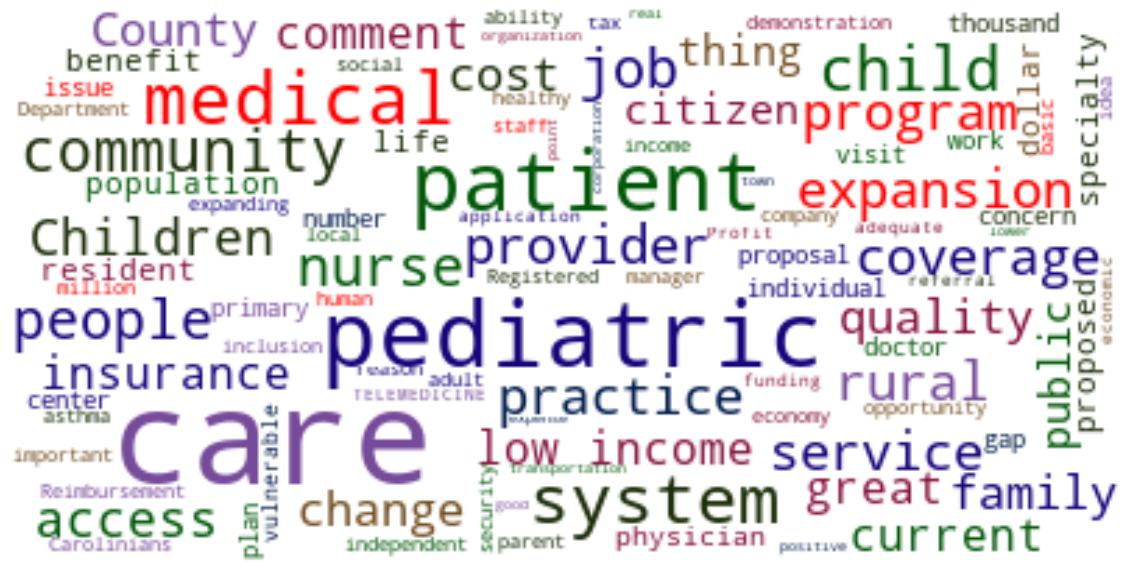

In [8]:
#Generate word cloud for positive sentiments
create_word_cloud (stopwords, pos_wordlist)

## <font color='blue'>Word cloud for negative sentiments</font>

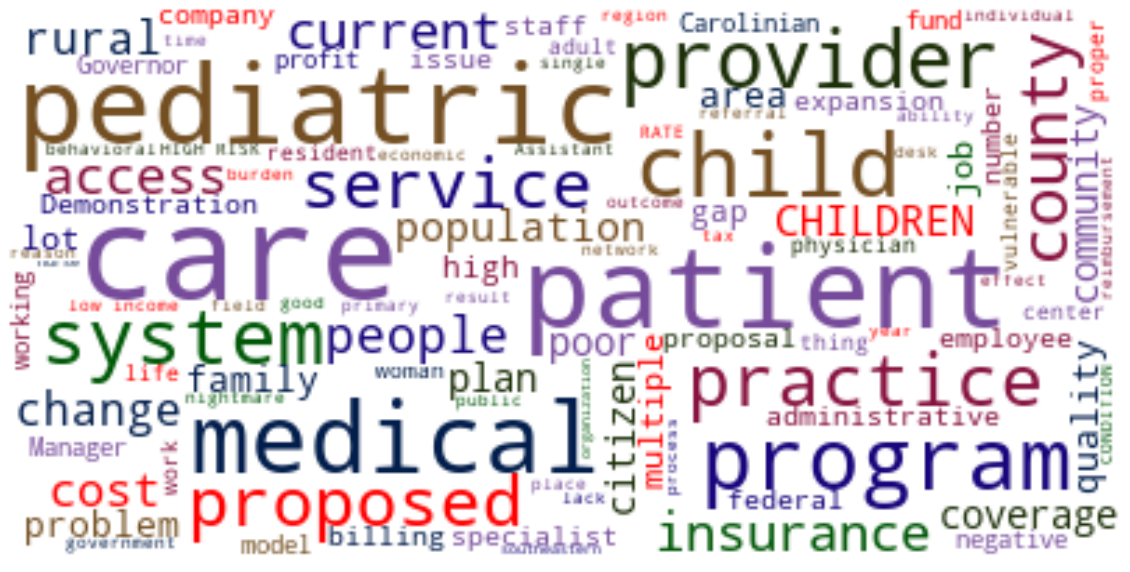

In [9]:
#Generate word cloud for negative sentiments
create_word_cloud (stopwords, neg_wordlist)